# Multi-output Regression Data EDA

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from notebook_utils import run_xgb_model, scores_barplot, \
    plot_feature_imps, run_lin_reg_model, print_results, run_models

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.expand_frame_repr', False)

sns.set_theme(style="whitegrid")

## Load & prep Data

In [2]:
# Load dataset from csv
data = pd.read_csv("data\\dataset-merged.csv")
data.drop(['sheepid'], axis=1, inplace=True)
print(data.head().transpose())

# Split training samples from labels
input_cols = ['breed', 'sex', 'slaughgr', 'slweight(g)']
X = data[input_cols]
y = data.drop(input_cols, axis=1)

# Split train & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=96)
print('Train set shape:', X_train.shape, y_train.shape)
print('Test set shape:', X_test.shape, y_test.shape)


                 0      1      2      3     4
breed            1      1      1      1     1
sex              1      1      1      1     0
slaughgr         1      1      1      1     1
slweight(g)  12399  12500  12300  12399  9500
woolfr         150    130    140    120   150
blood          575    575    600    625   475
feet           450    475    475    450   375
pelt          1250   1245   1200   1225  1000
fullGI        1400   1500   1300   1375  1375
mesent         100     75    100    125    70
epipl          150     75    125    250    50
liver          275    300    275    300   225
spleen          30     50     50     50    25
pluck          425    525    400    400   375
head           635    650    625    650   525
warmcarc      6850   6800   6875   6850  4825
kidney          32     32     32     34    26
KKCF           122     78    118    154    74
tail            32     32     44     32    32
coldcarc      6612   6542   6776   6642  4710
mw%             25     25     25  

## Summary
Σύνοψη του συνόλου δεδομένων.

In [3]:
print("Data shape:", data.shape, '\n')
data.info()
print("\nEmpty values/column sum:\n", data.isna().sum())
print('\nDescribe:')
data.describe()

Data shape: (119, 30) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119 entries, 0 to 118
Data columns (total 30 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   breed        119 non-null    int64
 1   sex          119 non-null    int64
 2   slaughgr     119 non-null    int64
 3   slweight(g)  119 non-null    int64
 4   woolfr       119 non-null    int64
 5   blood        119 non-null    int64
 6   feet         119 non-null    int64
 7   pelt         119 non-null    int64
 8   fullGI       119 non-null    int64
 9   mesent       119 non-null    int64
 10  epipl        119 non-null    int64
 11  liver        119 non-null    int64
 12  spleen       119 non-null    int64
 13  pluck        119 non-null    int64
 14  head         119 non-null    int64
 15  warmcarc     119 non-null    int64
 16  kidney       119 non-null    int64
 17  KKCF         119 non-null    int64
 18  tail         119 non-null    int64
 19  coldcarc     119 non-null 

,breed,sex,slaughgr,slweight(g),woolfr,blood,feet,pelt,fullGI,mesent,epipl,liver,spleen,pluck,head,warmcarc,kidney,KKCF,tail,coldcarc,mw%,WtBefDIS,LEG,CHUMP,LOIN,BREAST,BESTEND,MIDNECK,SHOULDER,NECK
count,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000
mean,1.991597,0.504202,2.983193,30293.310924,643.613445,1264.563025,697.445378,2588.478992,5596.344538,558.210084,782.890756,644.159664,62.394958,678.756303,1079.823529,15426.470588,49.764706,366.621849,76.277311,15031.361345,56.638655,7157.554622,1631.764706,690.563025,818.899160,735.529412,584.781513,1022.294118,1400.100840,251.529412
std,0.818181,0.502096,1.414113,15678.515993,353.645018,682.566737,283.001458,1232.859896,2630.089553,548.410135,941.082714,319.161879,30.964227,272.067195,419.041413,8655.367991,17.833840,366.340052,54.399639,8469.177268,27.255144,3959.369053,779.948485,406.575980,520.869504,483.940951,342.773759,578.012790,747.376954,157.972312
min,1.000000,0.000000,1.000000,9500.000000,120.000000,375.000000,300.000000,980.000000,1300.000000,50.000000,50.000000,175.000000,20.000000,275.000000,500.000000,4600.000000,14.000000,44.000000,20.000000,4434.000000,25.000000,2160.000000,546.000000,200.000000,216.000000,180.000000,170.000000,294.000000,452.000000,64.000000
25%,1.000000,0.000000,2.000000,17899.000000,330.000000,692.500000,475.000000,1632.500000,3455.000000,145.000000,150.000000,362.500000,40.000000,427.500000,713.000000,8375.000000,36.000000,98.000000,37.000000,8137.500000,35.000000,3910.000000,1015.000000,350.000000,398.500000,351.000000,293.000000,560.000000,761.500000,140.000000
50%,2.000000,1.000000,3.000000,25600.000000,600.000000,1100.000000,650.000000,2250.000000,5500.000000,325.000000,300.000000,575.000000,55.000000,625.000000,975.000000,12800.000000,46.000000,188.000000,54.000000,12450.000000,50.000000,5960.000000,1425.000000,608.000000,656.000000,584.000000,486.000000,852.000000,1150.000000,200.000000
75%,3.000000,1.000000,4.000000,39049.500000,950.000000,1837.500000,887.500000,3250.000000,7250.000000,762.500000,1075.000000,875.000000,80.000000,887.500000,1325.000000,20725.000000,64.000000,480.500000,98.000000,20200.000000,75.000000,9222.500000,2120.000000,933.000000,1097.000000,1047.000000,806.000000,1256.000000,1822.000000,308.000000
max,3.000000,1.000000,5.000000,71599.000000,1400.000000,3000.000000,1625.000000,6800.000000,11500.000000,2125.000000,4200.000000,1400.000000,150.000000,1400.000000,2250.000000,37400.000000,100.000000,1630.000000,276.000000,36500.000000,100.000000,17495.000000,3736.000000,1716.000000,2432.000000,2100.000000,1480.000000,2586.000000,3528.000000,902.000000


* Το σύνολο δεδομένων περιέχει 119 παραδείγματα εκπαίδευσης με 31 χαρακτηριστικά το κάθε ένα (119x31). Γνωρίζουμε ότι απο
αυτά τα 31 χαρακτηριστικά, τα 4 θα χρησιμοποιηθούν ως δεδομένα εισόδου και τα υπόλοιπα 26 (αγνοώντας το id) θα είναι τα
χαρακτηριστικά που προσπαθούμε να προβλέψουμε.

* Όπως είδαμε, δέν υπάρχουν χαρακτηριστικά με ελλειπείς τιμές.

* Η μεταβλητή εισόδου "slweight(g)" αντιπροσωπεύει το βάρος σε γραμμάρια του ζώου. Βλέπουμε ότι το βάρος
κυμαίνεται μεταξύ 9500 και 71599. Η σχετικά μικρή διαφορά που παρατηρείται μεταξύ του median και του μέσου (mean)
δείχνει ότι μάλλον δέν υπάρχουν πολλοί outliers στη μεταβλητή και πιθανότατα ωφείλεται στο γεγονός ότι, μάλλον είναι
λογικό να υπάρχουν μεγάλες αποκλείσεις στα βάρη των διαφορετικών ζώων.

* Η μεταβλητή εισόδου "sex" είναι κατηγορική μεταβλητή, υποδηλώνει το φύλλο του ζώου και παίρνει τις τιμές 0 ή 1.

* Η μεταβλητή εισόδου "breed" είναι κατηγορική μεταβλητή, υποδηλώνει τη ράτσα του ζώου και παίρνει τιμές απο 1 έως 3.

* Η μεταβλητή εισόδου "slaughgr" είναι κατηγορική μεταβλητή και παίρνει τιμές απο 1 έως 5.

* Οι υπόλοιπες 26 μεταβλητές είναι μεταβλητές στόχοι είναι συνεχείς μεταβλητές και με εξαίρεση το "mw%" δηλώνουν επιμέρους βάρη
σε γραμμάρια (g).

<AxesSubplot:title={'center':'Animal slaughgr'}, xlabel='slaughgr', ylabel='count'>

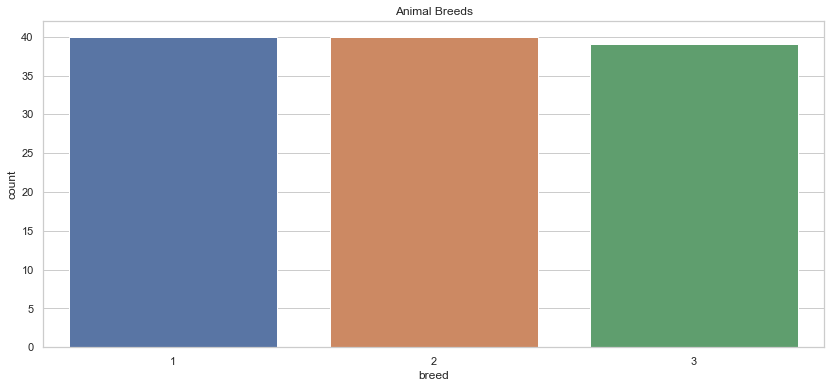

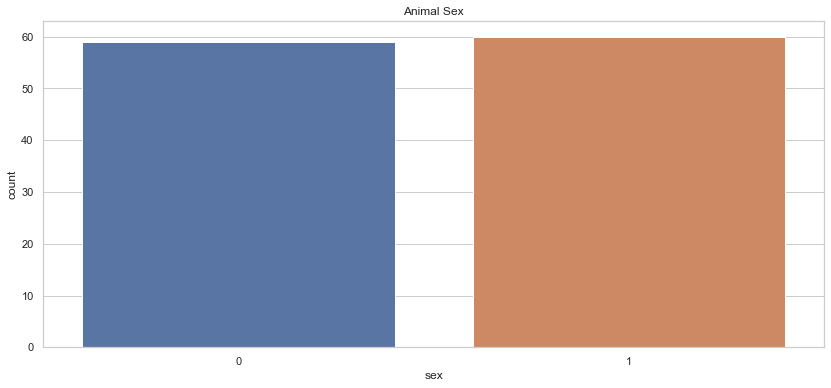

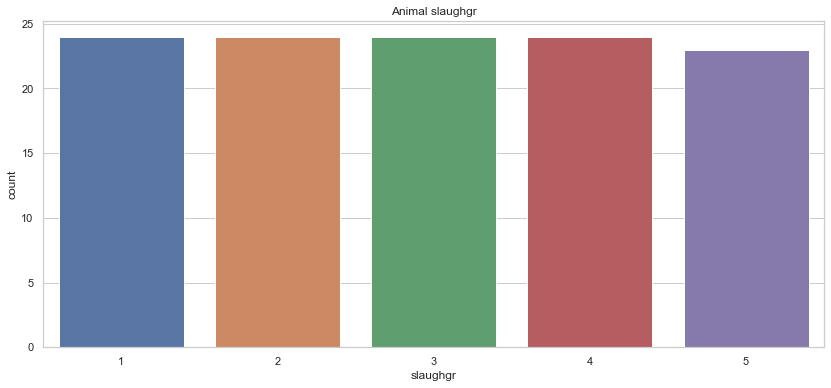

In [4]:
plt.figure(figsize=(14,6))
plt.title('Animal Breeds')
sns.countplot(x='breed', data=data)

plt.figure(figsize=(14,6))
plt.title('Animal Sex')
sns.countplot(x='sex', data=data)

plt.figure(figsize=(14,6))
plt.title('Animal slaughgr')
sns.countplot(x='slaughgr', data=data)

Όπως βλέπουμε παραπάνω, και για τα τρία κατηγορικά χαρακτηριστικά τα δεδομένα είνια κατανεμημένα ομοιόμορφα πράγμα που
σημαίνει ότι δεν υπάρχει μεροληψία ως προς κάποιο συγκεκριμένο χαρακτηριστικό.

## Examine Parts Variance
Θα χρησιοποιήσουμε boxplots για να διαπιστώσουμε τη διακύμανση που παρατηρείται στα βάρη
κάθε τμήματος του ζώου.

<AxesSubplot:>

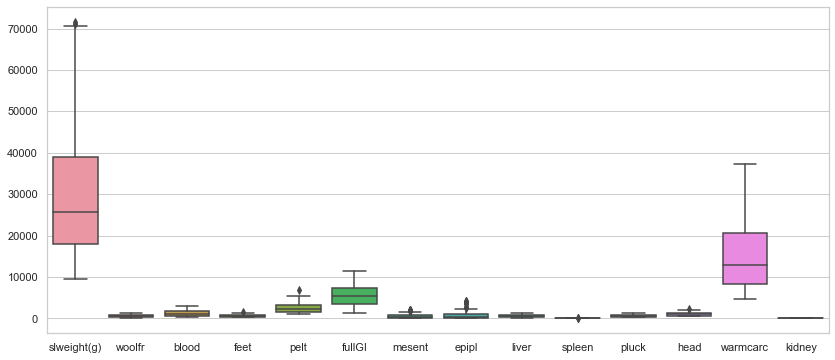

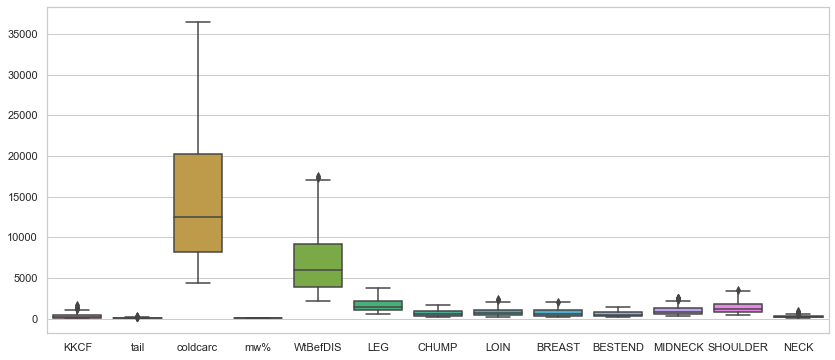

In [20]:
plt.figure(figsize=(14,6))
parts = data[['slweight(g)', 'woolfr','blood','feet','pelt','fullGI','mesent','epipl',
              'liver','spleen', 'pluck', 'head','warmcarc', 'kidney']]
sns.boxplot(data=parts)

plt.figure(figsize=(14,6))
parts = data[['KKCF', 'tail', 'coldcarc', 'mw%', 'WtBefDIS', 'LEG', 'CHUMP', 'LOIN',
              'BREAST', 'BESTEND', 'MIDNECK', 'SHOULDER', 'NECK']]
sns.boxplot(data=parts)

Απο τα baxplots παρατηρούμε ότι δεν παρατηρείται ιδιαίτερα μεγάλη διακύμανση στο βάρος των περισσότερων τμημάτων ζώων.
Τη μεγαλύτερη διακύμανση τη παρουσιάζουν τα ακόλουθα χαρακτηριστικά:"blood", "pelt", "fullGI" (?) και "WtfBefDIS" (?).
Επίσης, στο χαρακτηριστικό "epipl" κάποιες τιμές ξεφεύγουν και ίσως είναι outliers.

## Feature Correlation
Αρχικά θα διερευνήσουμε το βαθμό συσχέτισης μεταξύ όλων των χαρακτηριστικών.

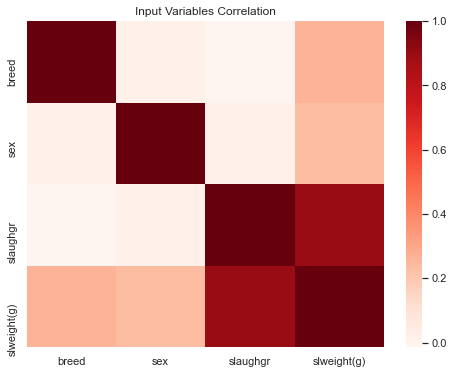

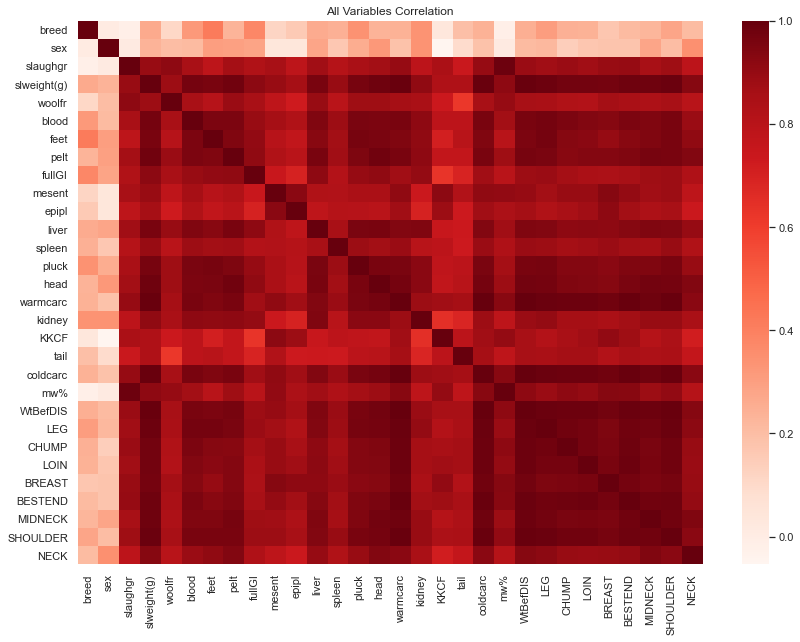

In [6]:
plt.figure(figsize=(8,6))
plt.title('Input Variables Correlation')
input_cols_corr = X.corr()
sns.heatmap(input_cols_corr, annot=False, cmap='Reds')
plt.show()

plt.figure(figsize=(14,10))
plt.title('All Variables Correlation')
output_cols_corr = data.corr()
sns.heatmap(output_cols_corr, annot=False, cmap='Reds')# sns.set(font_scale=0.5)
plt.show()


Παρά το γεγονός ότι τα δεδομένα είναι πάρα πολλά για να είμαστε σε θέση να κατανοήσουμε το heatmap λεπτομερώς μπορούμε
εξάγουμε μερικά συμπεράσματα απο τη γενική εικόνα τους.

Πιό συγκεκριμένα, στο 1ο heatmap βλέπουμε μια αναπαράσταση του βαθμού συσχέτισης μεταξύ των μεταβλητλών εισόδου. Απο την
αναπαράσταση αυτή είναι εμφανές ότι τα χαρακτηριστιά εισόδου είναι αρκετά ασυσχέτιστα μεταξύ τους αλλά και με τα υπόλοιπα
χαρακτηριστικά με εξαίρεση τα χαρ/κα "slweight(g)" και "slaughgr" τα οπόια παρουσιάζουν υψηλή συσχέτιση μεταξύ τους.

Στό 2ο  heatmap είναι εμφανές πως τα δεδομένα εξόδου έχουν υψηλή συσχέτιση μεταξύ τους αλλά καί με τα δεδομένα εισόδου καθώς
το μεγαλύτερο μέςρος του heatmap είναι βαθιά κοκκινισμένο. Επίσης επαληθέυεται αυτό που παρατηρήσαμε στο 1ο heatmap, δηλαδή
ότι οι συσχετίσεις μεταξύ των μεταβλητών εισόδου είναι χαμηλές σε σχέση με τις συσχετίσεις μεταξύ των δεδομένων εξόδου.

## Feature Importance
Θα κάνουμε μια ανάλυση της σημασίας των χαρακτηριστικών εισόδων στις εξόδους χρησιμοποιώντας τους συντελεστές που
προκύπτουν απο την εκπαίδευση μοντέλων παλλινδρόμησης όπως οι αλγόριθμος XGBoost και Linear Regression.
### XGBoost

XGBoost
R2 score: 0.89719535752799
MAE: 159.2544427193128
RMSE: 210.38222665792196
MAPE: 0.10833653086580594



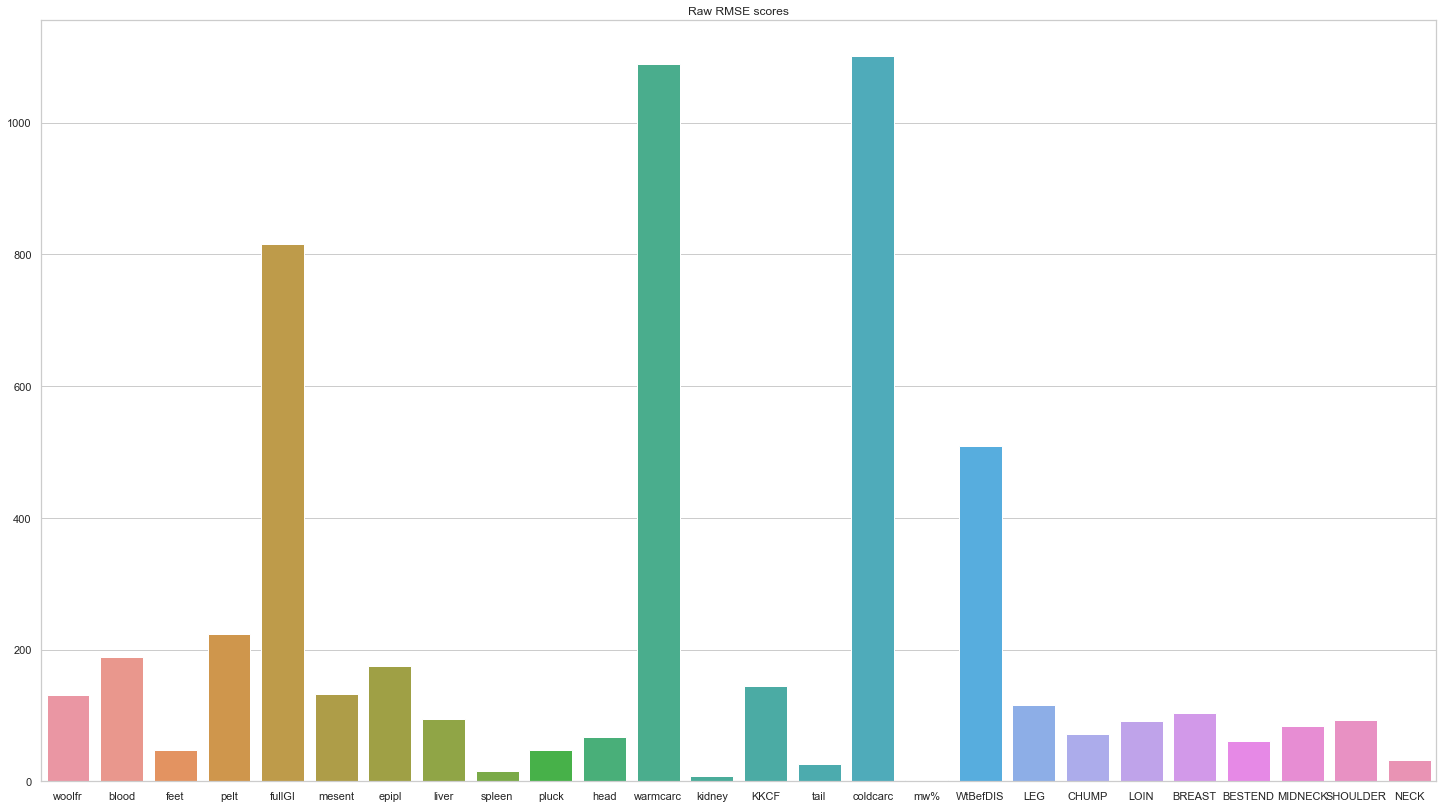

In [7]:
# Run xgboost model & get results
res = run_xgb_model(X_train, X_test, y_train, y_test)
# Print model scores (uniform average)
print_results(res)
# Plot individual target variable scores
scores_barplot(res['scores']['rv_scores_rmse'], y.columns, title='Raw RMSE scores')

Οι μεταβλητές "fullGI", "warmcarc", "coldcarc", "WtBefDIS" έχουν αρκετά μεγάλο σφάλμα (rmse) κατά την πρόβλεψη σε σχέση
με τις υπόλοιπες. Το μέσο ομοιόμορφο RMSE σφάλμα είναι 210.38.

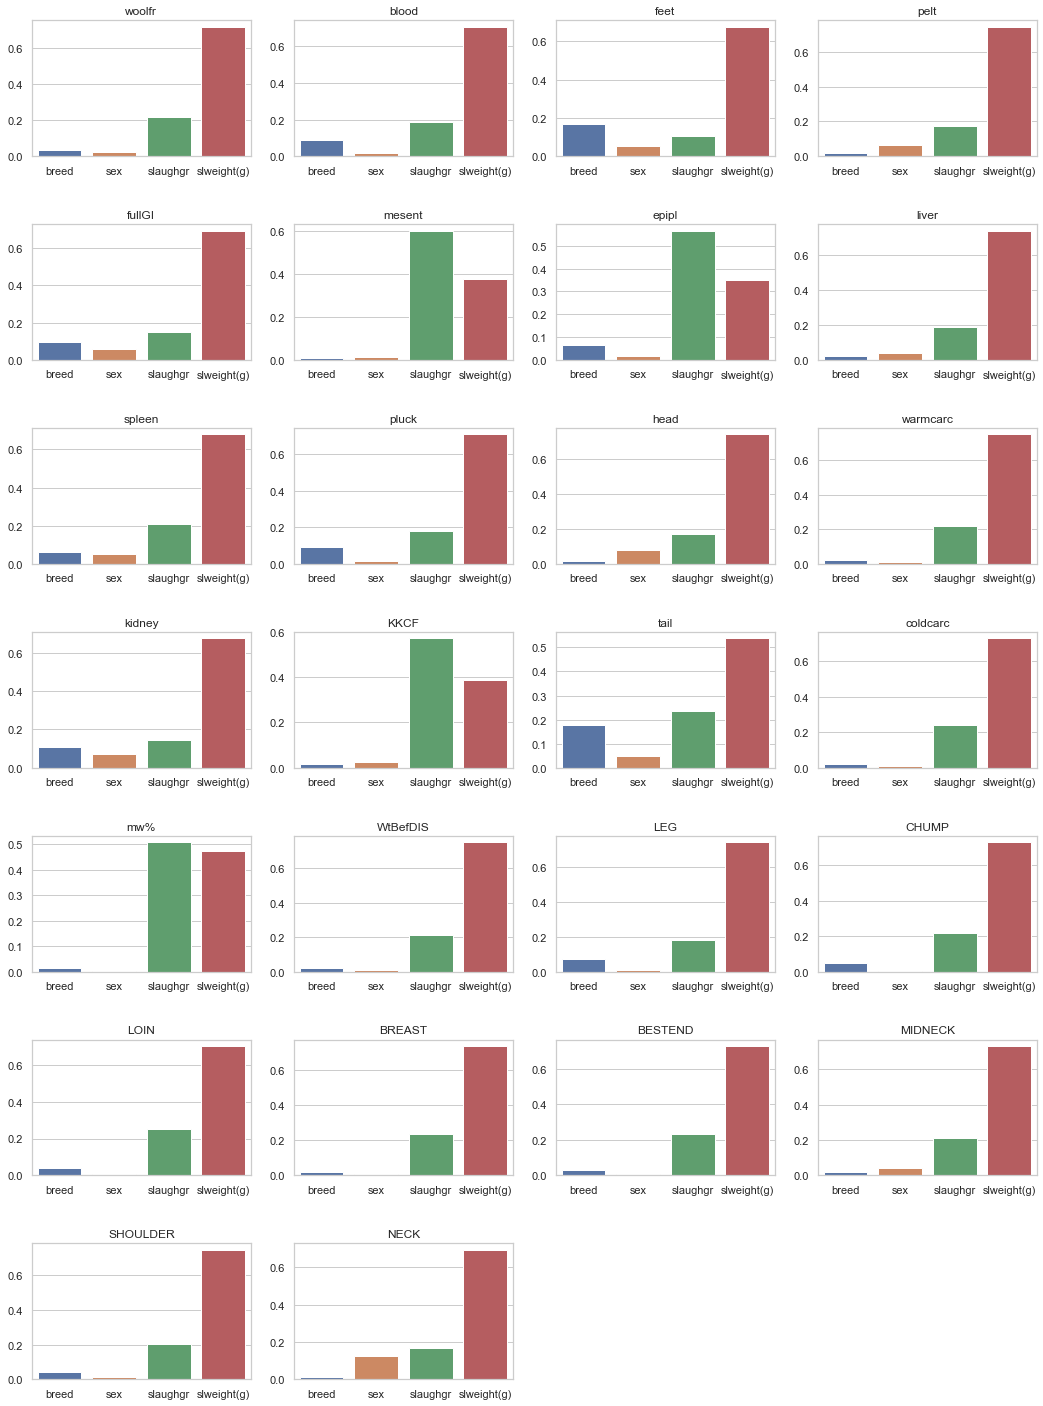

In [8]:
# Plot feature importances barplot for each target variable
plot_feature_imps(res['feat_imps'], X.columns, y.columns)

Είναι ξεκάθαρο ότι το πιό σημαντικό χαρακτηριστικό είναι το slweight(g), ενώ το breed και το sex επηρεάζουν πολύ λίγο
τη πρόβλεψη των μεταβλητών στόχων. Το slaughgr επίσης επηρεάζει αρκετά τις περισσότερες μεταβλητές στόχους.


### Linear Regression

Linear Regression
R2 score: 0.8723149739436958
MAE: 169.01673777083138
RMSE: 224.3894285471359
MAPE: 0.16523037506273916



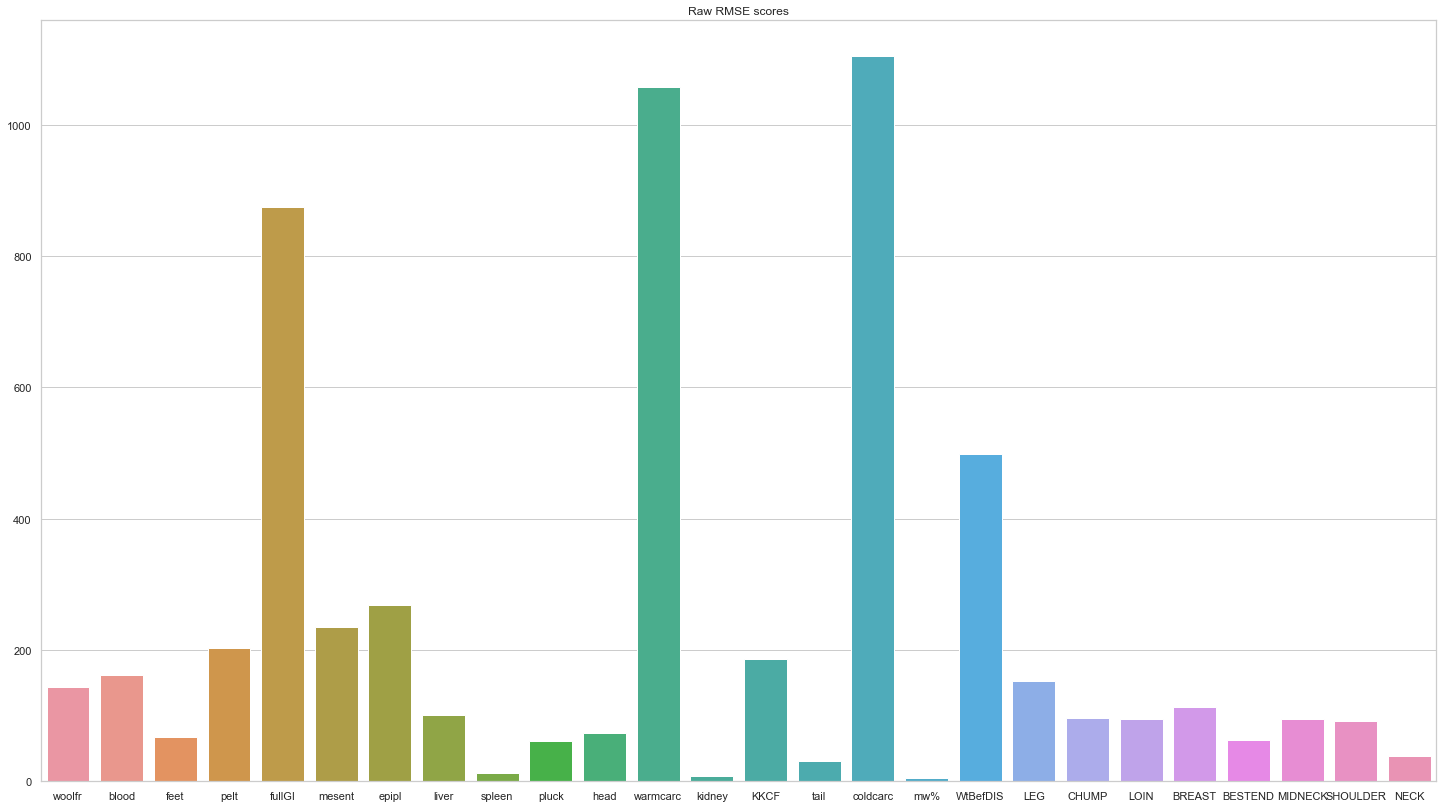

In [9]:
# Run Linear Regression model & get results
res = run_lin_reg_model(X_train, X_test, y_train, y_test)
print_results(res)
# Plot individual RMSE scores
scores_barplot(res['scores']['rv_scores_rmse'], y.columns, title='Raw RMSE scores')

Το μοντέλο Linear Regression επιτυγχάνει παρόμοια αποτελέσματα με το XGBoost με λίγο υψηλότερο RMSE περίπου στα 224.38.

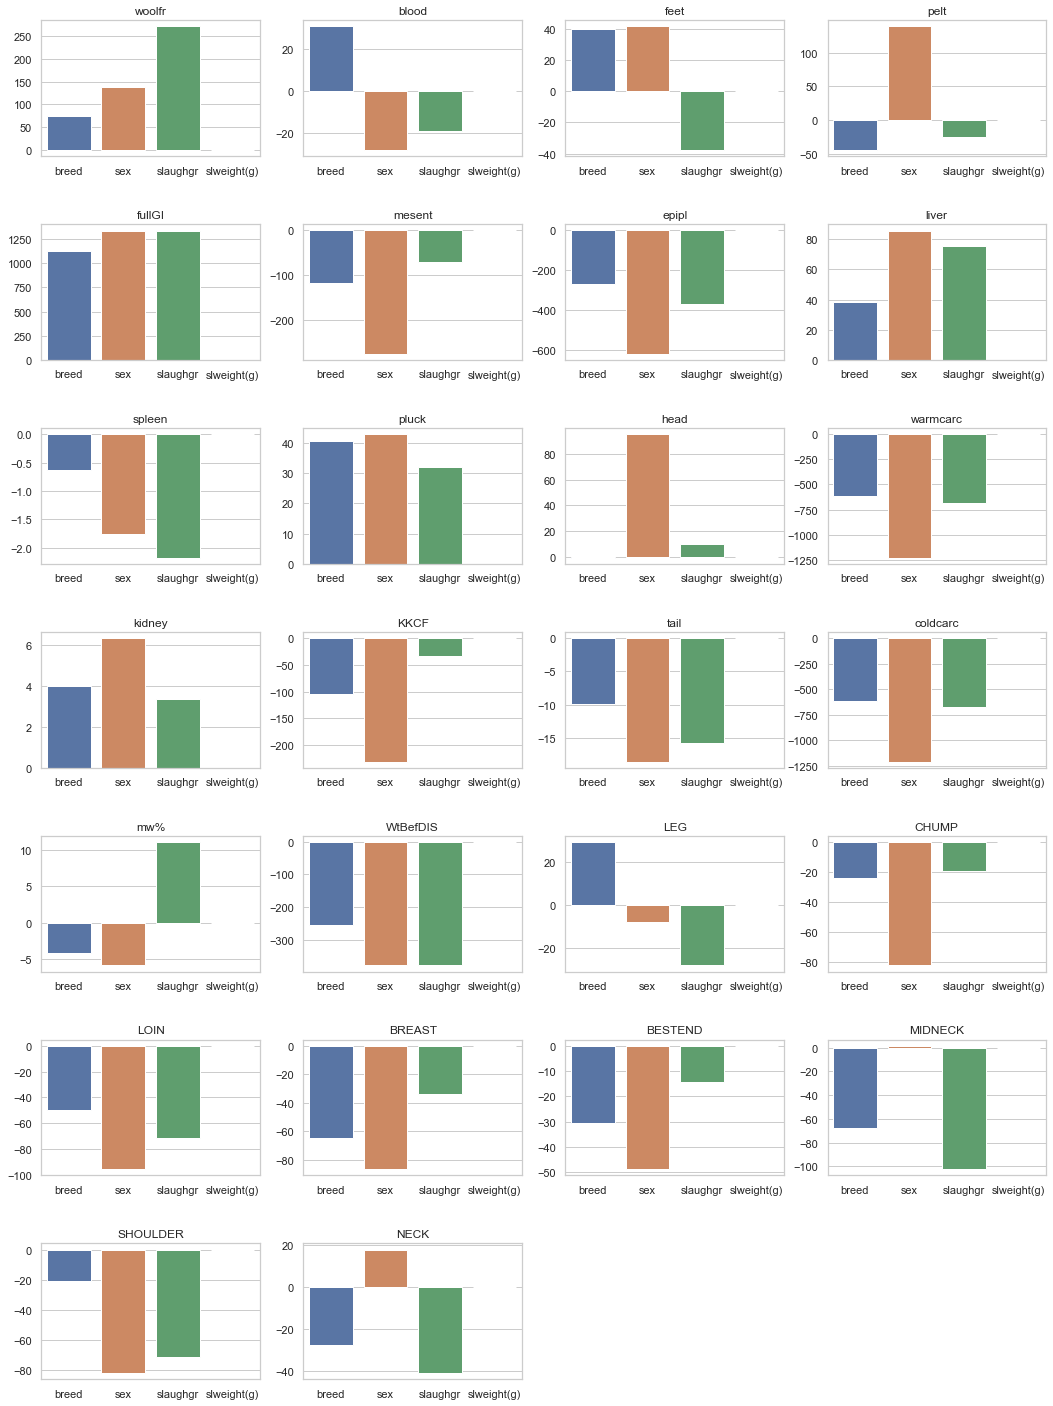

In [10]:
# Plot coefficients
plot_feature_imps(res['feat_imps'], X.columns, y.columns)

Όπως βλέπουμε στα παραπάνω barplots, δεν μπορούμε να βγάλουμε και πολλά συμπεράσματα απο τους συντελεστές που έχει
αναθέσει ο Linear Regression στις  μεταβλητές για το feature importance των μεταβλητών. Αυτό ωφείλεται πιθανότατα στο
διαφορετιλό scale που έχουν οι μεταβλητές. Παρακάτω θα δοκιμάσουμε να κάνουμε scale στα δεδομένα προτού τρέξουμε τον
Linear Regression προκειμένου να εξάγουμε μια καλύτερη αναπαράσταση.

### Linear Regression with Scaling

Κάνουμε scale τα δεδομένα χρησιμοποιώντας τον Standard scaler του sklearn και τρέχουμε
ξανά το Linear Regression μοντέλο.

In [11]:
# Scale data
std_scaler = StandardScaler()
X_scaled = pd.DataFrame(std_scaler.fit_transform(X), columns=X.columns)
y_scaled = pd.DataFrame(std_scaler.fit_transform(y), columns=y.columns)
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = \
    train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=96)


Linear Regression
R2 score: 0.8723149739436592
MAE: 0.20109338313382846
RMSE: 0.26302123147133977
MAPE: 1.123633535513544



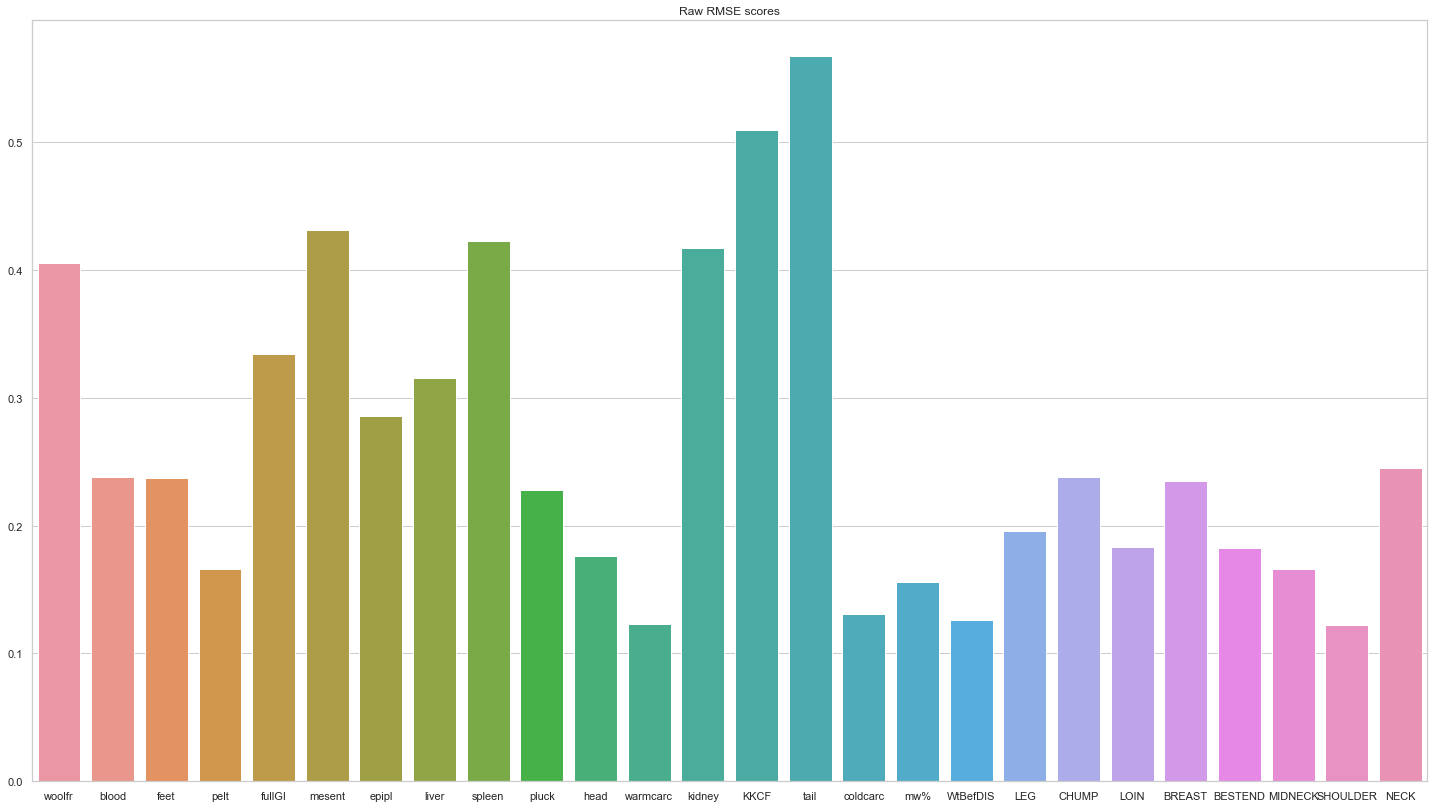

In [12]:
# Rerun Linear regression model on scaled data
res = run_lin_reg_model(X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled)
print_results(res)
# Plot individual RMSE scores
scores_barplot(res['scores']['rv_scores_rmse'], y.columns, title='Raw RMSE scores')

 * Με το scaling ο Linear regression επιτυγχάνει ακριβώς το ίδιο R2 score συγκριτκά με την εκτέλεση σε unscaled δεδομένα.
 * Το μέσο ομοιόμορφο RMSE είναι 0.263.
 * Επίσης παρατηρούμε ότι κάποιες μεταβλητές (όπως "warmcarc" και "coldcarc" που έχουν μεγάλη διακύμανση) έχου πλέον
 μικρότερο σφάλαμα συγκριτικά με τις υπόλοιοπες μεταβλητές.
 * Η μεταβλητή "tail" που πρίν το scaling είχε πολύ μικρό σφάλμα, τώρα έχει το
 μεγαλύτερο (κατά αναλογία πάντα με τις υπόλοιπες μεταβλητές).

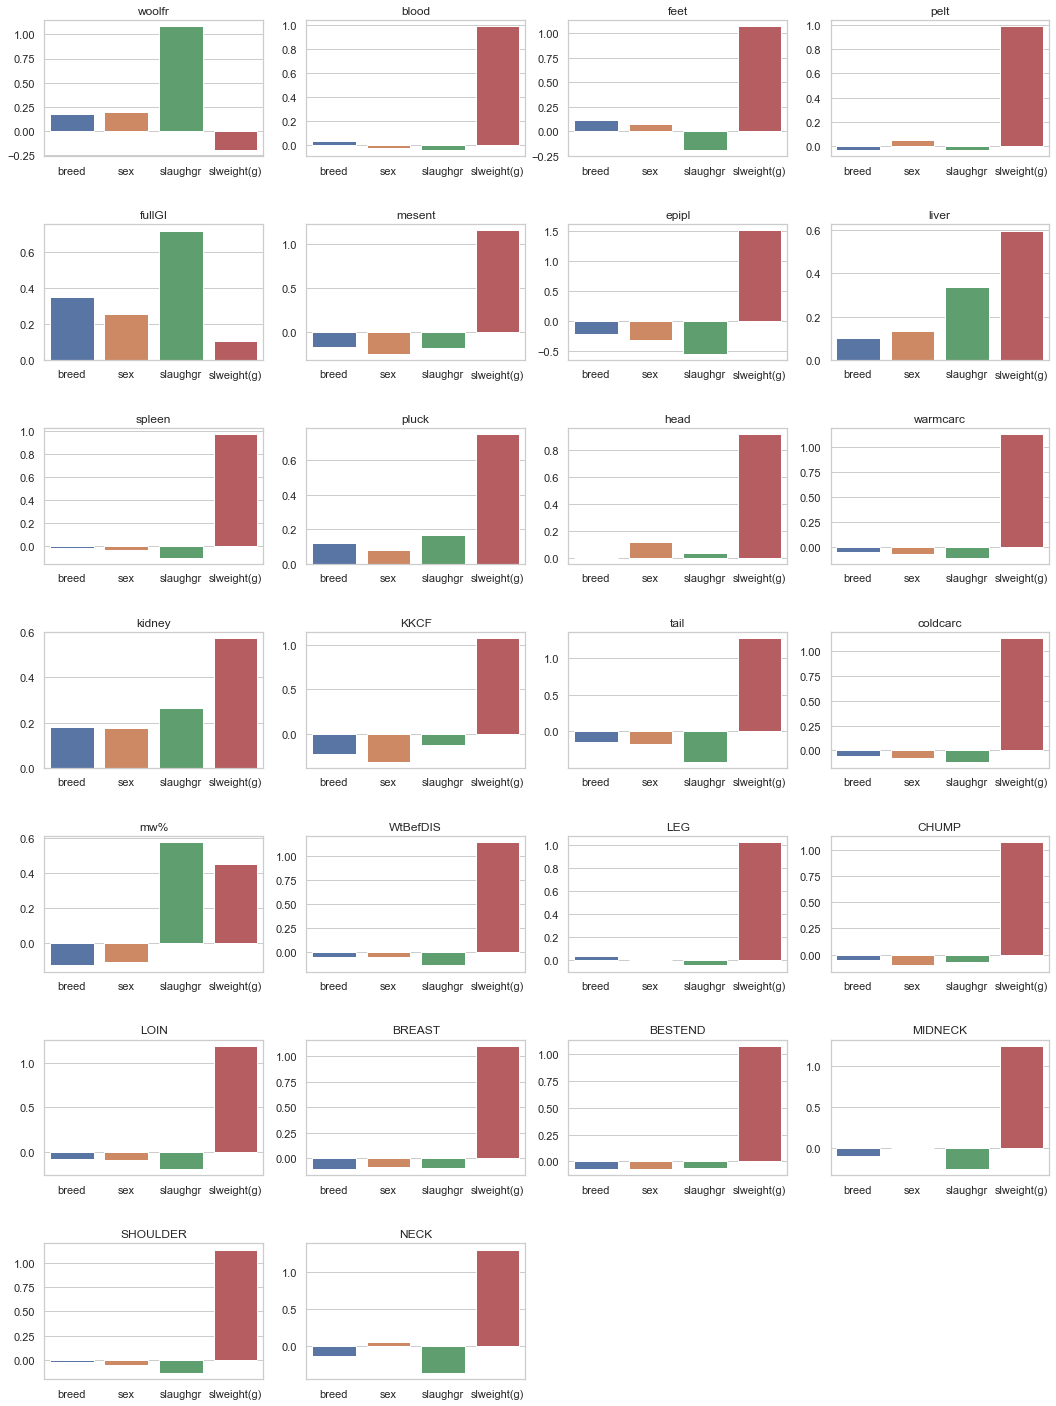

In [13]:
# Plot coefficients
plot_feature_imps(res['feat_imps'], X.columns, y.columns)

Παρατηρώντας τα barplots για κάθε μεταβλητή στόχο, βλέπουμε ότι και πάλι στις περισσότερες περιπτώσεις η μεταβλητή
"slweight(gr)" έχει το μεγαλύτερο importance για τη πρόβλεψη.
Οι αρνητικές τιμές των συντελεστών που παρατηρούνται σε κάποιες περιπτώσεις υποδηλώνουν αρνητική συσχέτιση.
Επίσης, αξίζει να σημειωθεί ότι οι μεταβλητές "slweight(gr)" και "slaughgr" έχουν πολύ υψηλή συσχέτιση όπως συζητήσαμε
παραπάνω (Multicolinearity). Απο αυτό το φαινόμενο μπορεί να επηρεαστεί ο linear regression ενώ τα δενδρικά μοντέλα
όπως ο XGBoost δεν επηρεάζονται.

### XGBoost with Scaling
Ας δοκιμάσουμε να τρέξουμε και τον XGBoost με scaling.

XGBoost
R2 score: 0.8988123054054284
MAE: 0.17275789646372036
RMSE: 0.2308907189117409
MAPE: 1.099207139021806



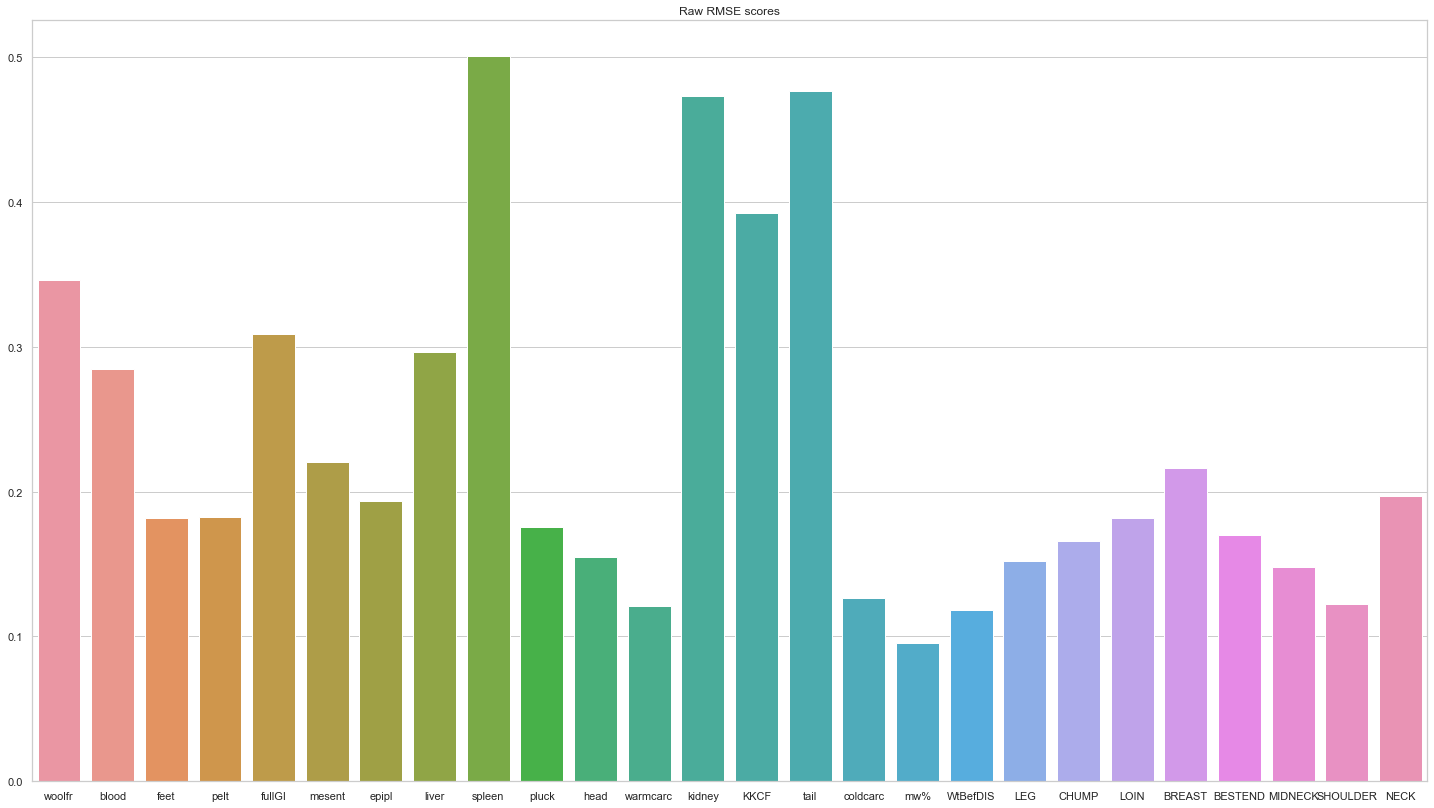

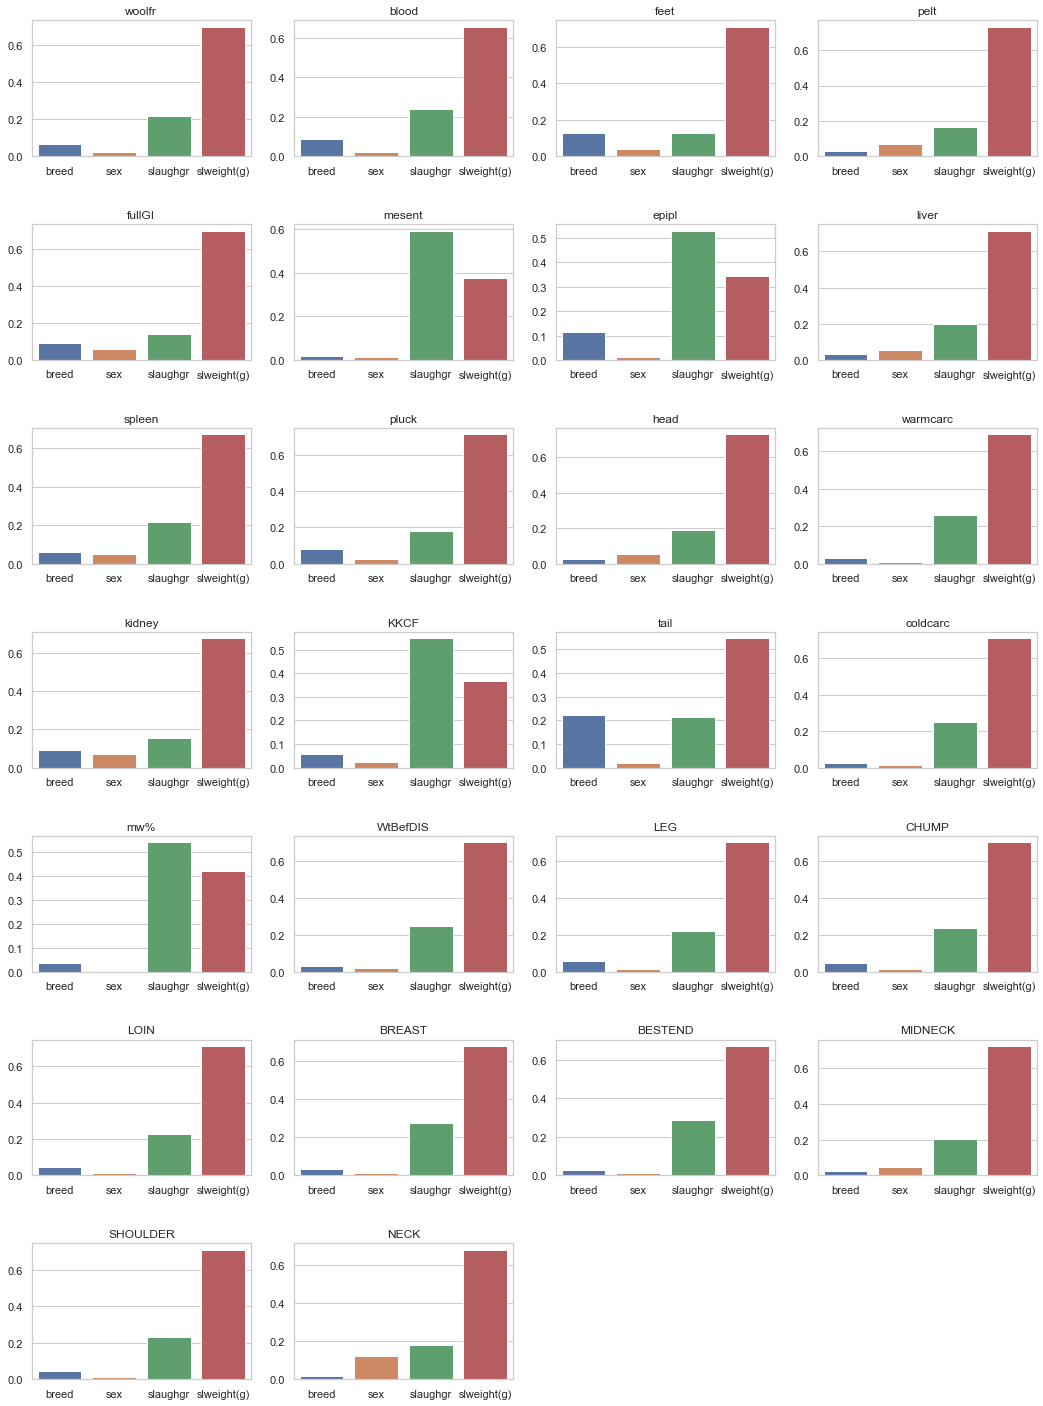

In [14]:
# Run xgboost model with scaling & get results
res = run_xgb_model(X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled)
print_results(res)
# Present raw rmse scores with a barplot
scores_barplot(res['scores']['rv_scores_rmse'], y.columns, title='Raw RMSE scores')
# Plot coefficients
plot_feature_imps(res['feat_imps'], X.columns, y.columns)

* O XGBoost εξακολουθεί να έχει λίγο καλύτερη απόδοση απο τον Linear Regression.
* Μέσο ομοιόμορφο RMSE 0.2309
* Ωστόσο, τα feature importances δεν επηρεάζονται ιδιαίτερα.
* Αυτό είναι αναμενόμενο καθώς ο XGBoost βασίζεται σε δένδρα απόφασης και επομένω δεν επηρρεάζεται απο το scaling.
Ωστόσο, αλγόριθμοι όπως ο linear regression είναι πιό ευαίσθητοι στο scaling και πολλές φορές είναι απαραίτητο.
* Θα συνεχίσουμε τα πειράματα χρησιμοποιώντας scaling απο εδώ και πέρα προκειμένου να μπορούμε να συγρίνουμε πιό εύκολα
τα αποτελέσματα των δύο μοντέλων.

## Αφαίρεση Μη-σημαντικών Χαρακτηριστικών
Για να κάνουμε πιό καθαρά τις δοκιμές χρησιμοποιώντας τα δύο μοντέλα κάθε φορά, θα χρησιμοποιήσουμε μια συνάρτηση που
τρέχει τα δύο μοντέλα και παρουσιάζει τα αποτελέσματα.

### Drop "sex" column

In [15]:
r = run_models(X_scaled.drop(['sex'], axis=1), y_scaled, show_plots=False)

XGBoost
R2 score: 0.8700890067375202
MAE: 0.19340769468312363
RMSE: 0.25837699583824214
MAPE: 1.2921591644726351

Linear Regression
R2 score: 0.8578035204310837
MAE: 0.2105480880963596
RMSE: 0.277416025186406
MAPE: 1.2875555187853531



* Ρίχνοντας τη στήλη 'sex' παρατηρούμε μια μικρή αύξηση στα RMSE και των δύο αλγορίθμων (~0.02) και μια μικρή μείωση στα R2
scores τους (0.02).
* Επομένως συμπαιρένουμε ότι ρίχνοντας το "sex" δέν αυξάνεται η επίδοση.

### Drop "breed" column

In [16]:
r = run_models(X_scaled.drop(['breed'], axis=1), y_scaled, show_plots=False)

XGBoost
R2 score: 0.8350567630640219
MAE: 0.23013856665236615
RMSE: 0.3007184080923543
MAPE: 1.2178343768231463

Linear Regression
R2 score: 0.8514259515371843
MAE: 0.21885164624401834
RMSE: 0.2836536657610177
MAPE: 1.2235774340922674



* Ρίχνοντας τη στήλη "breed" ανεβαίνει το σφάλμα.
* Επομένως θα κρατήσουμε το χαρακτηριστικό.
* XGBoost επηρεάστηκε περισσότερο αφου το σφάλμα του ανέβηκε περισσότερο σε σχέση με τον Linear Regression.

### Drop "slaughgr" column
Παρόλο που το χαρακτηριστικό "slaughgr" είναι σχετικά σημαντικό για τη πρόβλεψη πολλών εξόδων είδαμε παραπάνω πώς έχει
πολύ υψηλό correlation με το χαρακτηριστικό "weight(gr)" γεγονός που γενά το ερώτημα: Πόση παραπάνω πληροφορία προσφέρει
πραγματικά το χαρακτηριστικό "slaughgr";

XGBoost
R2 score: 0.8219657684804148
MAE: 0.24691288747798998
RMSE: 0.315965114804946
MAPE: 1.3655479736296918

Linear Regression
R2 score: 0.8612833282751129
MAE: 0.20994260863014425
RMSE: 0.273989035952174
MAPE: 1.2005734719658294



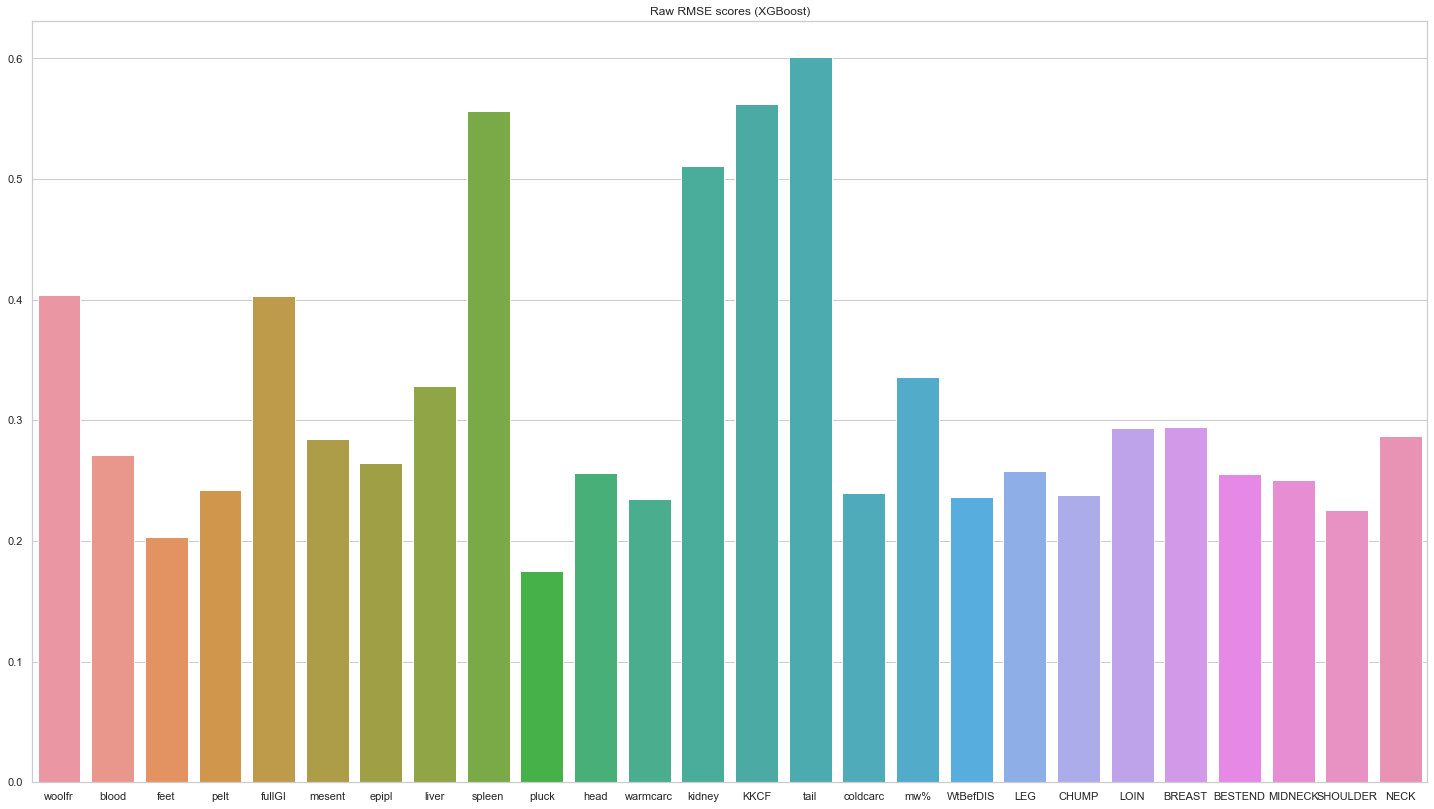

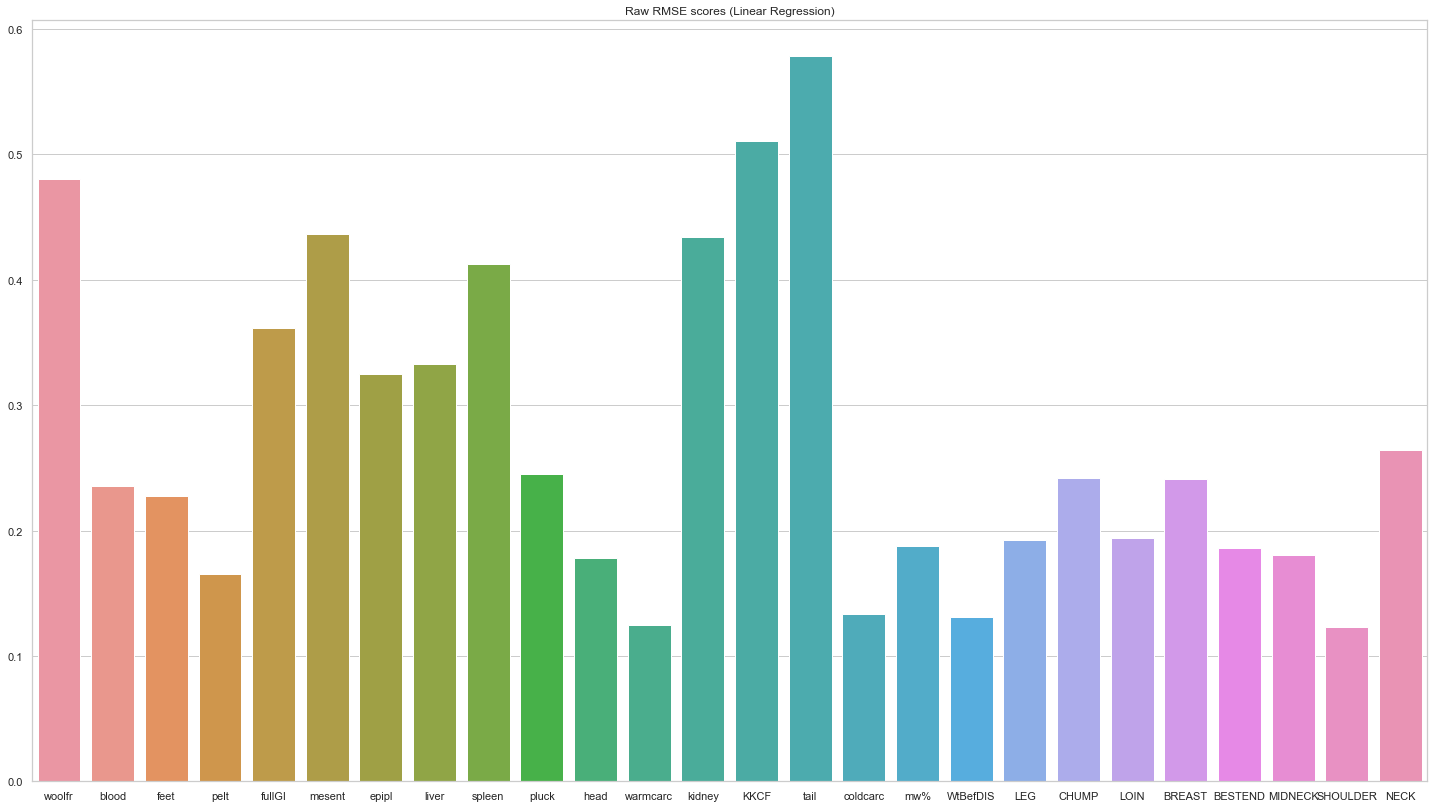

In [17]:
r = run_models(X_scaled.drop(['slaughgr'], axis=1), y_scaled, show_plots=True)

* Παρατηρούμε πως παρόλο που το importance του "slaughgr" φαίνεται να είναι υψηλό για πολλές μεταβλητές εξόδου,
η μή χρήση του αύξησε λίγο το σφάλμα (περίπου όσο και μη χρήση των φαινομενικά λιγότερο σημαντικών features "sex"
και "breed").
* O XGBoost φαίνεται πως και πάλι επηρρεάστηκε περισσότερο σε σχέση με τον Linear Regression αφου η αύξηση στο σφάλμα
του είναι μεγαλύτερη.

### Συμπεράσματα
* Άν και ο XGBoost έχει σε γενικές γραμμές μικρότερο σφάλμα απο τον Linear Regression φαίνεται πως είναι πιό ευαίσθητος
στην αφαίρεση ακόμα και μη σημαντικών χαρακτηριστικών και καταλήγει να έχει μεγαλύτερο σφαλμα σε σχέση με τον
Linear Regression.
* Παρόλο που και τα τρία χαρακτηριστικά που δοκιμάσαμε να αφαιρέσουμε είναι μή σημαντικά, η αφαίρεσή τους είχε ως
αποτέλεσμα τη μικρή αύξηση του σφάλματος επομένως για την ώρα θα κρατήσουμε όλα τα χαρακτηριστικά.

## Χαρακτηριστικά Εξόδου Στην Είσοδο

Όπως είδαμε παραπάνω, οι μεταβλητές στόχοι έχουν υψηλή συσχέτιση μεταξύ τους (pearson correlation).
Επομένως, θα εκμεταλλευτούμε αυτό το γεγονός χρησιμοποιώντας τες στην είσοδο.

In [18]:
# A dataframe to hold test results & one for the plot presentation data
res_df = pd.DataFrame(columns=['Output Feature Used',
                               'XGBoost RMSE',
                               'Linear Regression RMSE',
                               'XGBoost R2',
                               'Linear Regression R2'])
plot_df = pd.DataFrame(columns=['Model',
                                'Output Feature Used',
                                'RMSE',
                                'R2 score'])

for col in y_scaled.columns:
    # Reset alternative X (assign by value)
    X_alt = X_scaled.loc[:]
    # Add current column from y (targets) to X (inputs)
    X_alt[col] = y_scaled[[col]]
    # Remove current column from y (targets)
    y_alt = y_scaled.drop([col], axis=1)

    # Run both models for current configuration & get results
    r = run_models(X_alt, y_alt, show_plots=False, show_results=False)
    res_df = res_df.append({
        'Output Feature Used': col,
        'XGBoost RMSE': r['xgb']['scores']['ua_score_rmse'],
        'Linear Regression RMSE': r['lr']['scores']['ua_score_rmse'],
        'XGBoost R2': r['xgb']['scores']['ua_score_r2'],
        'Linear Regression R2': r['lr']['scores']['ua_score_r2']
    }, ignore_index=True)
    plot_df = plot_df.append({
        'Model': r['xgb']['model'],
        'Output Feature Used': col,
        'RMSE':  r['xgb']['scores']['ua_score_rmse'],
        'R2 score': r['xgb']['scores']['ua_score_r2']
    }, ignore_index=True)
    plot_df = plot_df.append({
        'Model': r['lr']['model'],
        'Output Feature Used': col,
        'RMSE':  r['lr']['scores']['ua_score_rmse'],
        'R2 score': r['lr']['scores']['ua_score_r2']
    }, ignore_index=True)

print(res_df)


   Output Feature Used  XGBoost RMSE  Linear Regression RMSE  XGBoost R2  Linear Regression R2
0               woolfr      0.237958                0.245229    0.891834              0.885701
1                blood      0.249451                0.261938    0.883263              0.873477
2                 feet      0.238247                0.262679    0.893840              0.870921
3                 pelt      0.247488                0.252726    0.884324              0.880925
4               fullGI      0.241337                0.248490    0.890832              0.881573
5               mesent      0.244103                0.250597    0.886007              0.882085
6                epipl      0.247231                0.251819    0.885549              0.883553
7                liver      0.253192                0.250620    0.880212              0.882883
8               spleen      0.229503                0.257526    0.901629              0.875846
9                pluck      0.251047              

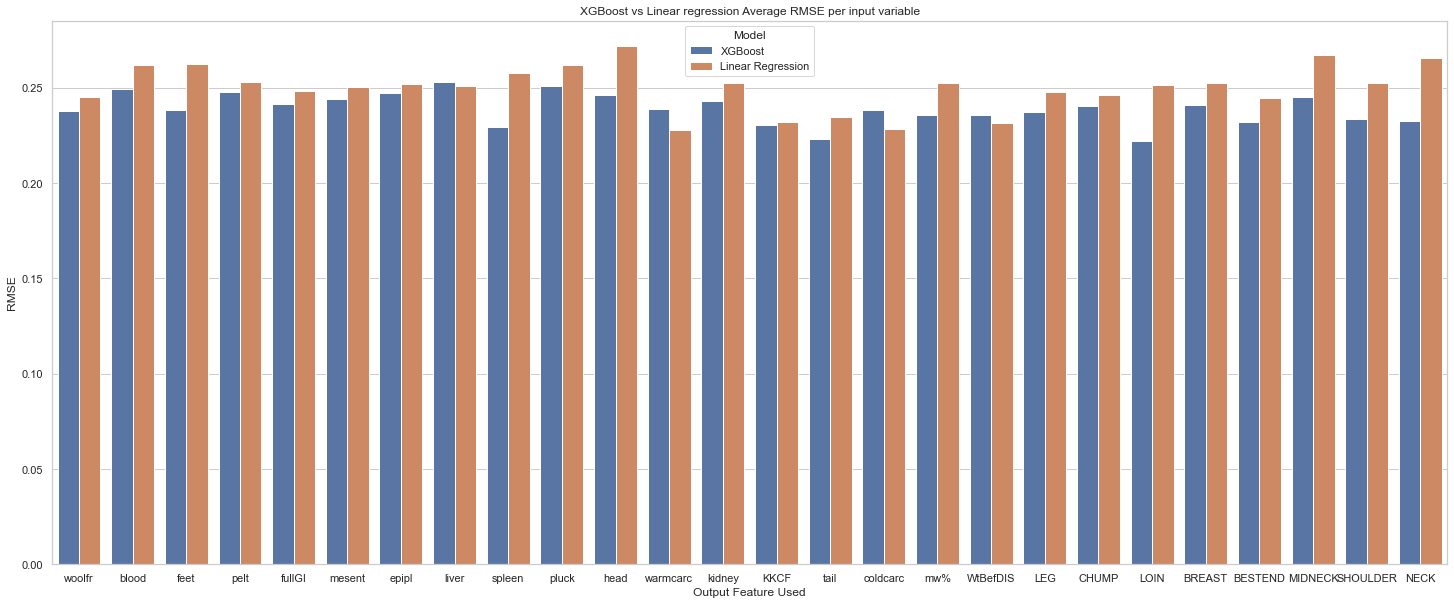

In [19]:
xgb_scores_df = pd.DataFrame([np.array(res_df['XGBoost RMSE'])], columns=y_scaled.columns)
lr_scores_df = pd.DataFrame([np.array(res_df['Linear Regression RMSE'])], columns=y_scaled.columns)
plt.figure(figsize=(25,10))
plt.title('XGBoost vs Linear regression Average RMSE per input variable')
sns.barplot(x="Output Feature Used", y="RMSE", hue="Model", data=plot_df)
plt.show()

* Στην περίπτωση του XGBoost, το μικρότερο σφάλμα το έδωσε η χρήση του χαρακτηριστκού "LOIN" στην είσοδο.
Πιό συγκεκριμένα το μέσο RMSE μειώθηκε απο 0.23089 σε 0.2219.
* O Linear Regression, συνεχίζει να έχει σε γενικές γραμμές υψηλότερο σφάλμα απο τον XGBoost με το μικρότερο σφάλμα να
το δίνει η χρήση του χαρακτηριστικού "warmcarc" στην είσοδο.
Πιό συγκεκριμένα το μέσο RMSE μειώθηκε απο 0.26302 σε 0.2280.
* Παρόλο που ο Linear Regression φαίνεται πως γενικά έχει μεγαλύτερο σφάλμα η χρήση κατάλληλης μεταβλητής
στην είσοδο επιφέρει πιό δραστική μείωση του σφάλματος σε σχέση με τον XGBoost.

* Ωστόσο, στην περίπτωση του XGBoost, για την αρχική πρόβλεψη του "LOIN" έχουμε πιό υψηλό σφάλμα σε σχέση με άλλα
χαρακτηριστικά, ενώ στην περίπτωση του Linear Regression το "warmcarc" τυχαίνει να είναι και το χαρακτηριστικό με
το μικρότερο σφάλμα κατά την αρχική πρόβλεψη.
* Επομένως, ίσως θα ήταν καλύτερο να ξεκινήσουμε προβλέποντας το χαρ/κο "warmcarc" με Linear Regression ??